In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spa
import scipy.sparse.linalg as spalin
from scipy.optimize import fsolve
from tqdm import trange
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import os
import sys
sys.path.append("../dyn/")
sys.path.append("../")
sys.path.append("../phase/")
sys.path.append("../artfigs_NC/")
from dyn_ultis import *
from spatial_ultis import *
from artfigs_NC_params import *
from artfigs_NC_ultis import *

In [29]:
def generate_params_phase_alpha_d_II_L_chaos(trial1:int, trial2:int, trial_num:int = 21):
    trial_num = trial_num

    N_E, N_I = 40000, 10000
    alpha = 0.95
    g_bar_EE, g_bar_IE, g_bar_EI, g_bar_II = 5.5, 5, -5, -4.25
    d_EE, d_IE, d_EI, d_II = 0.05, 0.05, 0.05, 0.12
    conn_NEE, conn_NIE, conn_NEI, conn_NII = tuple(alpha * np.array([2*np.pi * N_E * d_EE **2, 2*np.pi * N_I * d_IE **2, 2*np.pi * N_E * d_EI **2,2*np.pi * N_I * d_II **2]))
    g_EE, g_EI, g_IE, g_II = 0.55, 0.55, 0.55, 0.55

    alpha_list = np.linspace(0.1, 0.7, trial_num)
    d_II_list = np.linspace(0.05, 0.12, trial_num)
    
    d_II = d_II_list[trial2]
    alpha = alpha_list[trial1]
    conn_NEE, conn_NIE, conn_NEI, conn_NII = tuple(alpha * np.array([2*np.pi * N_E * d_EE **2, 2*np.pi * N_I * d_IE **2, 2*np.pi * N_E * d_EI **2,2*np.pi * N_I * d_II **2]))

    p_net = Network_Params(N_E = N_E, N_I = N_I,
        N_EE = conn_NEE, N_IE = conn_NIE, N_EI = conn_NEI, N_II = conn_NII,
        d_EE = d_EE, d_IE = d_IE, d_EI = d_EI, d_II = d_II,
        g_bar_EE = g_bar_EE, g_bar_EI = g_bar_EI, g_bar_IE = g_bar_IE, g_bar_II = g_bar_II,
        g_EE = g_EE, g_EI = g_EI, g_IE = g_IE, g_II = g_II
        )
    
    return p_net  

In [30]:
# p_simul = Simul_Params(T = 2000, t_step=5, record_step=10, activation_func=['thres_linear','thres_powerlaw'], external_input="DC_noise",tau_m=20.0)
p_simul = Simul_Params(T = 2000, t_step=5, record_step=10, activation_func=['tanh','tanh_high'], external_input="noise",tau_m=20.0)
generate_phase_params = generate_params_phase_alpha_d_II_L_chaos

trial_num_theo = 11

radius_list = np.zeros((trial_num_theo, trial_num_theo))
max_real_list = np.zeros((trial_num_theo, trial_num_theo))
max_imag_list = np.zeros((trial_num_theo, trial_num_theo))
phase_diagram = np.full((trial_num_theo, trial_num_theo), np.nan)
wavenum_list = np.zeros((trial_num_theo, trial_num_theo))
freq_list = np.zeros((trial_num_theo, trial_num_theo))
for trial1 in trange(trial_num_theo):
    for trial2 in range(trial_num_theo):
        p_net = generate_phase_params(trial1, trial2, trial_num_theo)
        p_net_eff = calc_eff_p_net(p_net, p_simul)
        radius = calc_pred_radius(p_net_eff, dim=2)
        radius_list[trial1, trial2] = radius
        if radius <= 1:
            p_net_eff_4outlier = p_net_eff
        else:
            p_net_eff_4outlier = calc_eff_p_net_with_variance(p_net, p_simul)

        lambda_list_pred_select,label_list_pred_select = calc_pred_outliers(p_net_eff_4outlier, dim=2, radius_filter=False)
        real_part_pred_select = np.real(lambda_list_pred_select)
        imag_part_pred_select = np.imag(lambda_list_pred_select)
        if len(lambda_list_pred_select) != 0:
            max_real_index = np.argmax(real_part_pred_select)
            max_real_list[trial1, trial2] = real_part_pred_select[max_real_index]
            max_imag_list[trial1, trial2] = imag_part_pred_select[max_real_index]
            wavenum = label_list_pred_select[max_real_index]
            wavenum_list[trial1, trial2] = np.sqrt(wavenum[1]**2 + wavenum[2]**2)            
            freq_list[trial1, trial2] = np.abs(imag_part_pred_select[max_real_index])/(2*np.pi)
        else: 
            max_real_list[trial1, trial2] = 0
            max_imag_list[trial1, trial2] = 0
            wavenum_list[trial1, trial2] = 0
            freq_list[trial1, trial2] = 0

        #TEMP 最好把各种分界都画出来，想一下怎么做
        if radius <= 1 and max_real_list[trial1, trial2] <= 1:
            phase_diagram[trial1, trial2] = 0
        elif radius >= 1 and max_real_list[trial1, trial2] <= 1:
            phase_diagram[trial1, trial2] = 1
        elif max_imag_list[trial1, trial2] <= 0:
            if wavenum_list[trial1, trial2] <= 0:
                phase_diagram[trial1, trial2] = 2
            if wavenum_list[trial1, trial2] > 0:
                phase_diagram[trial1, trial2] = 3
        elif max_imag_list[trial1, trial2] > 0:
            if wavenum_list[trial1, trial2] <= 0:
                phase_diagram[trial1, trial2] = 4
            if wavenum_list[trial1, trial2] > 0:
                phase_diagram[trial1, trial2] = 5

100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


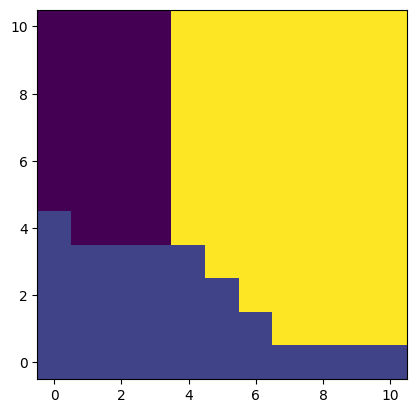

In [31]:
plt.imshow(phase_diagram,origin='lower')

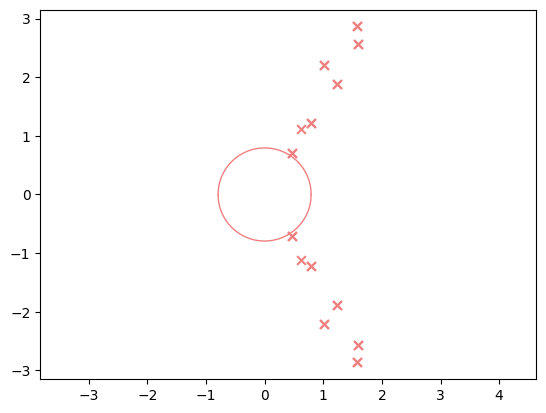

In [17]:
p_net = generate_params_phase_alpha_d_II_L_chaos(20, 20)
temp_plot_pred(p_net)

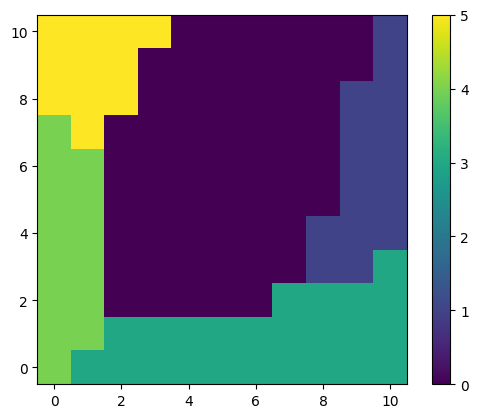

In [5]:
plt.imshow(phase_diagram,origin='lower')
plt.colorbar()

In [21]:
trial1, trial2 = 0, 10
t_step_onset = 500
record_x = np.load(r"../../data/artfigs_NC_"+'homo_d_II_g_bar_II_thres_L'+'_'+str(trial1)+'_'+str(trial2)+'_'+str(0)+r'.npy')
activated_x = activation_func_thres_linear(record_x)
np.mean(np.std(activated_x[t_step_onset::,0:p_net.N_E],axis=0)/(np.mean(activated_x[t_step_onset::,0:p_net.N_E],axis=0) + 1e-5))

0.72715116

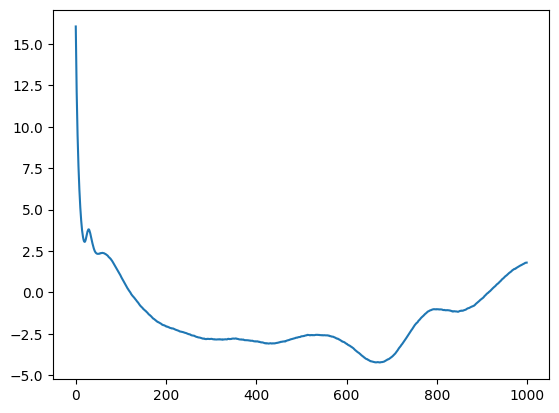

In [22]:
plt.plot(record_x[:,500])